<a href="https://colab.research.google.com/github/mohammadsjahanbakhsh/arima/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# connect to google drive in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# !pip install pmdarima

In [54]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error , r2_score
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

In [55]:
df = pd.read_csv("/content/drive/MyDrive/XAUUSD.csv (1).xls",header=1)

In [56]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Change(Pips)', 'Change(%)'], dtype='object')

In [57]:
df.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Change(Pips)      int64
Change(%)       float64
dtype: object

In [58]:
# convert datatype "Date" to datetime and set its to index
df["Date"] = pd.to_datetime(df.Date)
df.set_index("Date",inplace=True)

In [59]:
df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Change(Pips)      int64
Change(%)       float64
dtype: object

## fill nan

مقدار دهی کردن تاریخ هایی که ناموجود است با مقادیر قبل  
اگر دو روز متوالی ناموجود بود روز دوم را با مقداری که در روز بعد رخ داده پر کرده ام

In [60]:
# پیدا کردن اولین و اخرین تاریخ
min_date = df.index.min()
max_date = df.index.max()

In [61]:
# تولید لیستی از کل تاریخ ها
date_list = pd.date_range(min_date,max_date,freq="D")
# تغییر ایندکس به لیست تاریخ کامل
# سپس پر کردن مقدار ناموجود با مقدار روز قبل
df = df.reindex(date_list).ffill(limit=1)


In [62]:
df

,Open,High,Low,Close,Change(Pips),Change(%)
2021-07-04,1787.22,1787.73,1785.00,1786.39,-83.0,-0.05
2021-07-05,1786.68,1794.00,1783.80,1791.15,447.0,0.25
2021-07-06,1790.85,1814.89,1789.89,1795.68,483.0,0.27
2021-07-07,1795.28,1809.50,1793.41,1803.22,794.0,0.44
2021-07-08,1803.29,1818.00,1793.90,1803.75,46.0,0.03
...,...,...,...,...,...,...
2023-06-30,1908.71,1922.61,1900.57,1919.20,1049.0,0.55
2023-07-01,1908.71,1922.61,1900.57,1919.20,1049.0,0.55
2023-07-02,1920.30,1920.30,1917.50,1917.70,-260.0,-0.14
2023-07-03,1917.70,1930.50,1910.11,1921.17,347.0,0.18


In [63]:
df.isna().sum()

Open            5
High            5
Low             5
Close           5
Change(Pips)    5
Change(%)       5
dtype: int64

In [64]:
## پر کردن با مقدار بعدی
df.fillna(method="backfill",limit=1 , inplace=True)

In [65]:
df.isna().sum()

Open            0
High            0
Low             0
Close           0
Change(Pips)    0
Change(%)       0
dtype: int64

In [66]:
df


,Open,High,Low,Close,Change(Pips),Change(%)
2021-07-04,1787.22,1787.73,1785.00,1786.39,-83.0,-0.05
2021-07-05,1786.68,1794.00,1783.80,1791.15,447.0,0.25
2021-07-06,1790.85,1814.89,1789.89,1795.68,483.0,0.27
2021-07-07,1795.28,1809.50,1793.41,1803.22,794.0,0.44
2021-07-08,1803.29,1818.00,1793.90,1803.75,46.0,0.03
...,...,...,...,...,...,...
2023-06-30,1908.71,1922.61,1900.57,1919.20,1049.0,0.55
2023-07-01,1908.71,1922.61,1900.57,1919.20,1049.0,0.55
2023-07-02,1920.30,1920.30,1917.50,1917.70,-260.0,-0.14
2023-07-03,1917.70,1930.50,1910.11,1921.17,347.0,0.18


## Separation of data into two groups of training and testing

In [67]:
df2 = df.copy()
df = df["Close"]

In [68]:
df.tail()

2023-06-30    1919.20
2023-07-01    1919.20
2023-07-02    1917.70
2023-07-03    1921.17
2023-07-04    1929.65
Freq: D, Name: Close, dtype: float64

In [69]:
df.head()

2021-07-04    1786.39
2021-07-05    1791.15
2021-07-06    1795.68
2021-07-07    1803.22
2021-07-08    1803.75
Freq: D, Name: Close, dtype: float64

In [70]:
train = df[:"2023-06-03"]
train

2021-07-04    1786.39
2021-07-05    1791.15
2021-07-06    1795.68
2021-07-07    1803.22
2021-07-08    1803.75
               ...   
2023-05-30    1958.60
2023-05-31    1966.31
2023-06-01    1976.87
2023-06-02    1948.00
2023-06-03    1948.00
Freq: D, Name: Close, Length: 700, dtype: float64

In [71]:
test = df["2023-06-04":]
test

2023-06-04    1949.30
2023-06-05    1961.24
2023-06-06    1963.20
2023-06-07    1944.39
2023-06-08    1965.33
2023-06-09    1960.49
2023-06-10    1960.49
2023-06-11    1959.83
2023-06-12    1959.86
2023-06-13    1943.93
2023-06-14    1945.16
2023-06-15    1958.25
2023-06-16    1957.50
2023-06-17    1957.50
2023-06-18    1957.00
2023-06-19    1952.19
2023-06-20    1937.06
2023-06-21    1933.91
2023-06-22    1914.43
2023-06-23    1920.79
2023-06-24    1920.79
2023-06-25    1925.29
2023-06-26    1922.28
2023-06-27    1915.39
2023-06-28    1909.58
2023-06-29    1908.76
2023-06-30    1919.20
2023-07-01    1919.20
2023-07-02    1917.70
2023-07-03    1921.17
2023-07-04    1929.65
Freq: D, Name: Close, dtype: float64

# نمایش وضعیت داده ها با نمودار

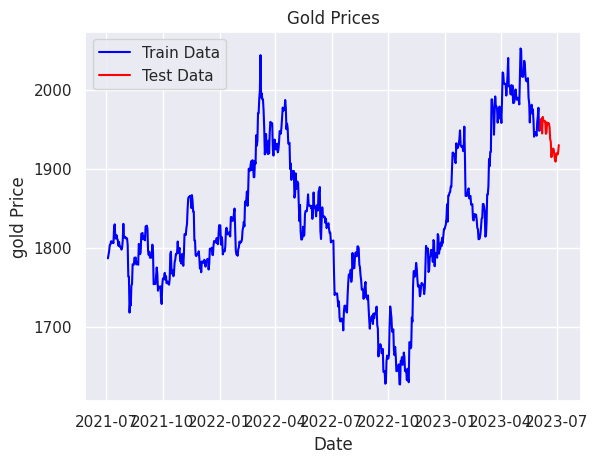

In [72]:
plt.plot(train,color="blue",label="Train Data")
plt.plot(test,color="red",label="Test Data")
plt.xlabel("Date")
plt.ylabel("gold Price")
plt.title("Gold Prices")
plt.legend()
plt.show()

In [73]:
# تنظیم تم برای نمودار ها
sns.set_theme()


Text(0.5, 1.0, 'Distribution of the Close price of gold')

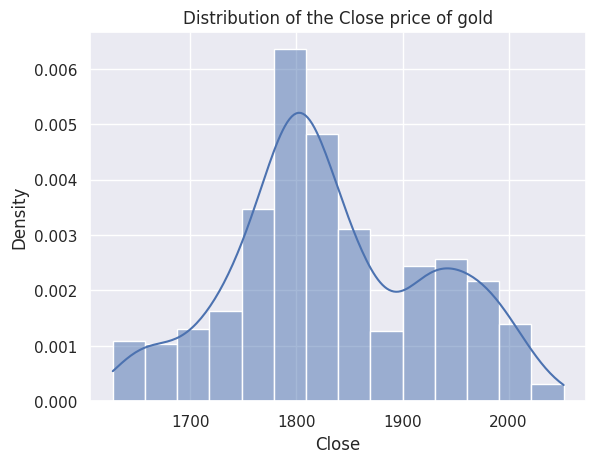

In [74]:
# kde = True خط نرمال میندازد
# stst="density" محور وای ها را تراکم درنظرمیگیرد
sns.histplot(df,kde=True,stat="density")
plt.title('Distribution of the Close price of gold')


<ipython-input-75-3b56ef7cd68b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df)


Text(0.5, 1.0, 'Distribution of the Close price of gold')

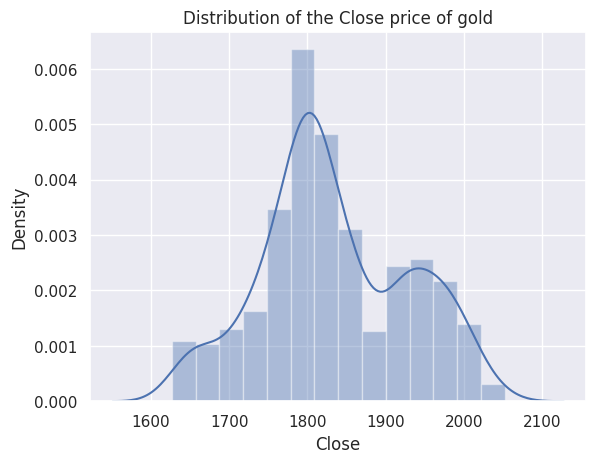

In [75]:
sns.distplot(df)
plt.title('Distribution of the Close price of gold')

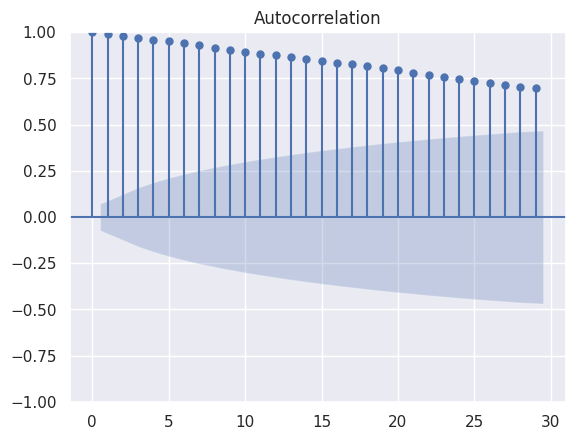

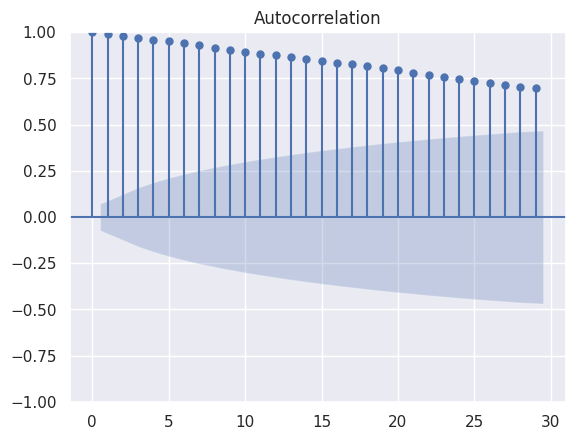

In [76]:
plot_acf(df)
# plt.savefig("acf.jpg")

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


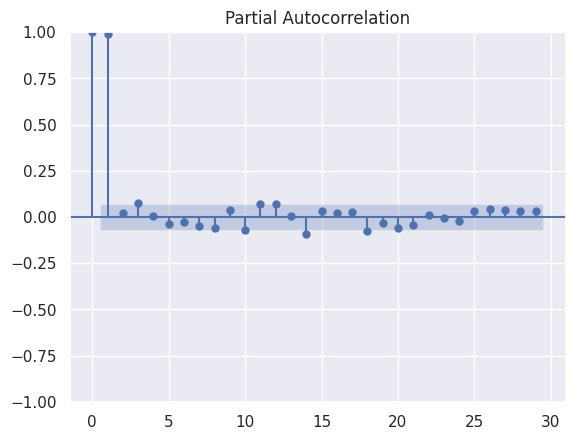

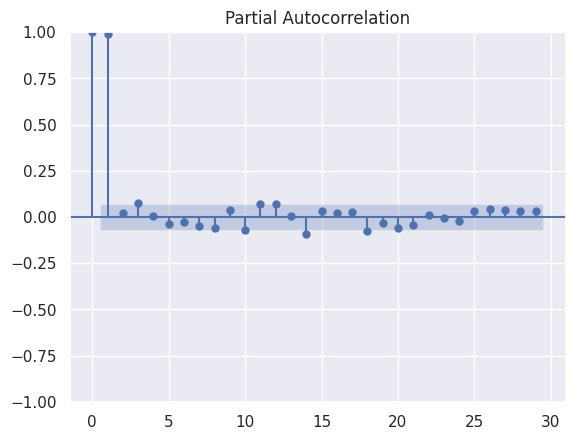

In [77]:
plot_pacf(df)

In [78]:
df2.columns

Index(['Open', 'High', 'Low', 'Close', 'Change(Pips)', 'Change(%)'], dtype='object')

<Axes: >

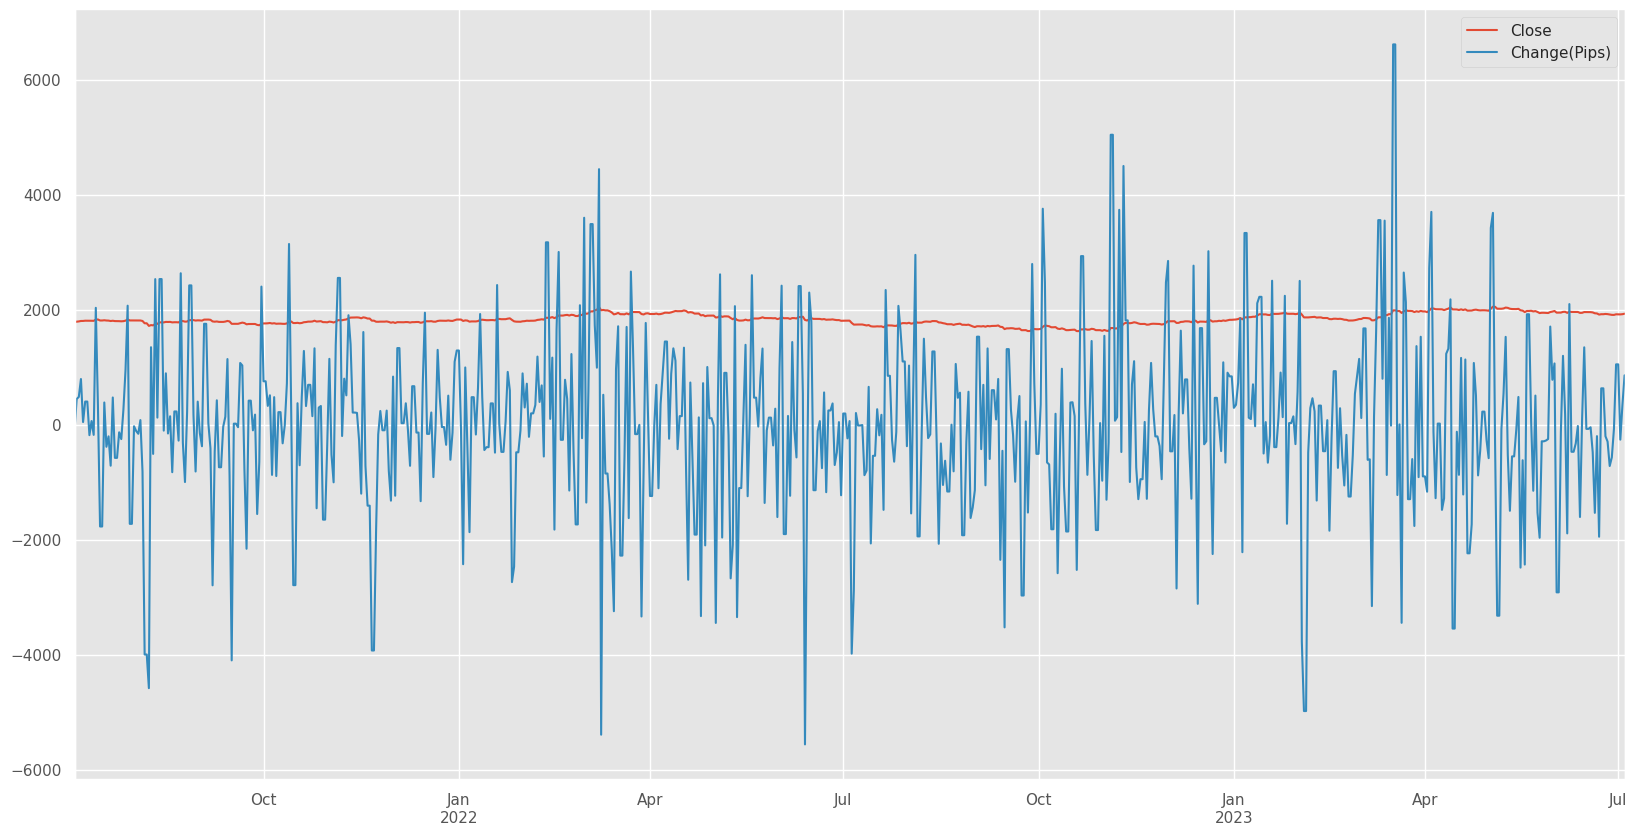

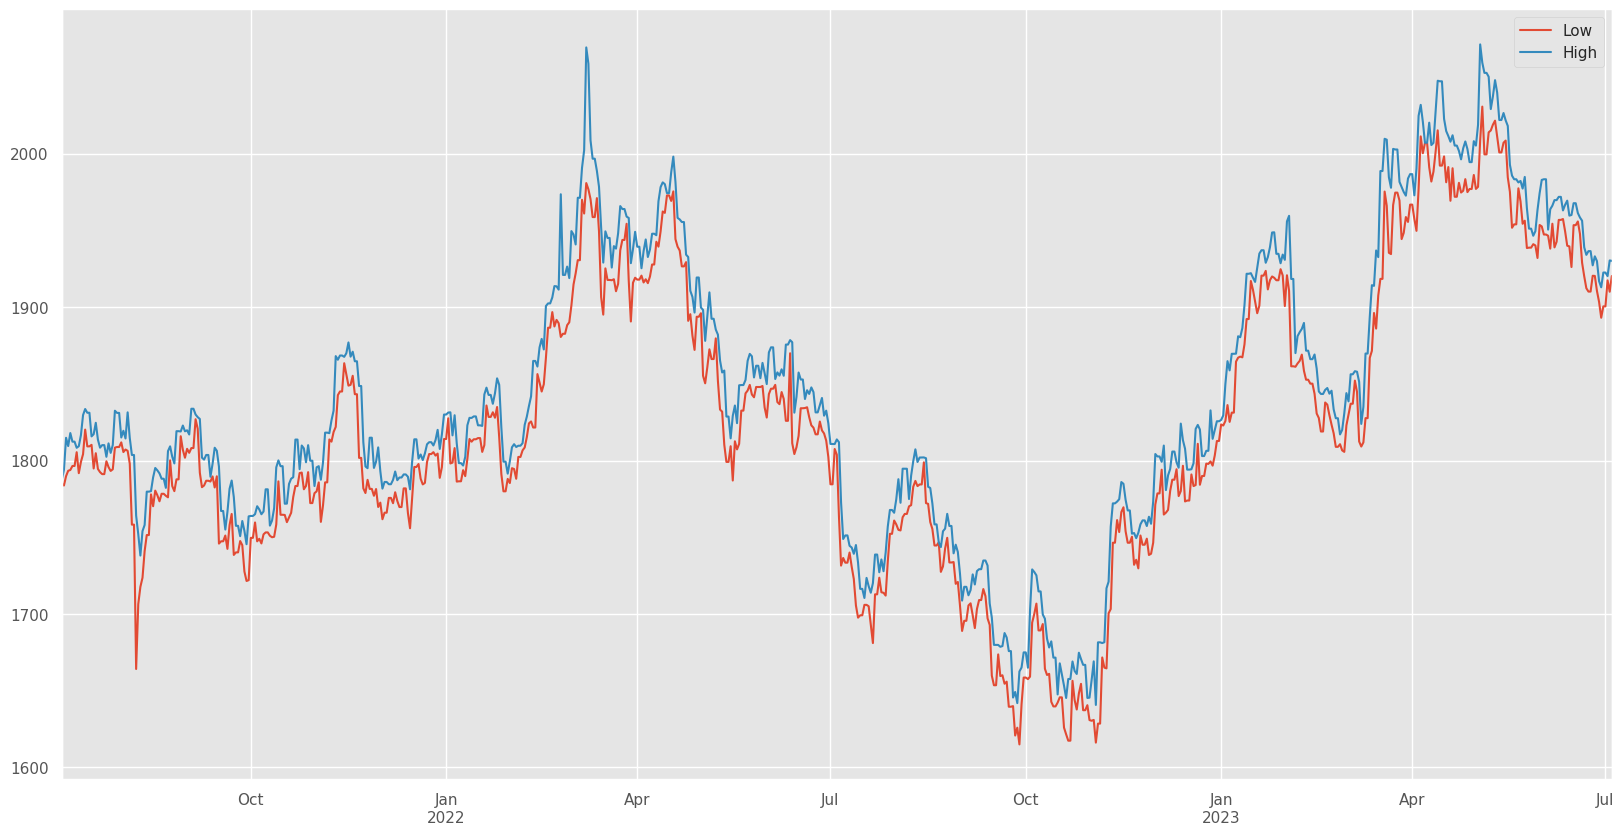

In [79]:
plt.rcParams["figure.figsize"] = (20.0,10.0)
plt.rcParams.update({"font.size":12})
plt.style.use("ggplot")
df2.loc[:,["Close","Change(Pips)"]].plot()
df2.loc[:,["Low","High"]].plot()

In [80]:
df.describe()

count     731.000000
mean     1833.560752
std        93.921691
min      1626.890000
25%      1775.680000
50%      1815.670000
75%      1914.610000
max      2051.930000
Name: Close, dtype: float64

In [81]:
test


2023-06-04    1949.30
2023-06-05    1961.24
2023-06-06    1963.20
2023-06-07    1944.39
2023-06-08    1965.33
2023-06-09    1960.49
2023-06-10    1960.49
2023-06-11    1959.83
2023-06-12    1959.86
2023-06-13    1943.93
2023-06-14    1945.16
2023-06-15    1958.25
2023-06-16    1957.50
2023-06-17    1957.50
2023-06-18    1957.00
2023-06-19    1952.19
2023-06-20    1937.06
2023-06-21    1933.91
2023-06-22    1914.43
2023-06-23    1920.79
2023-06-24    1920.79
2023-06-25    1925.29
2023-06-26    1922.28
2023-06-27    1915.39
2023-06-28    1909.58
2023-06-29    1908.76
2023-06-30    1919.20
2023-07-01    1919.20
2023-07-02    1917.70
2023-07-03    1921.17
2023-07-04    1929.65
Freq: D, Name: Close, dtype: float64

# ساخت مدل

<Figure size 2000x1000 with 0 Axes>

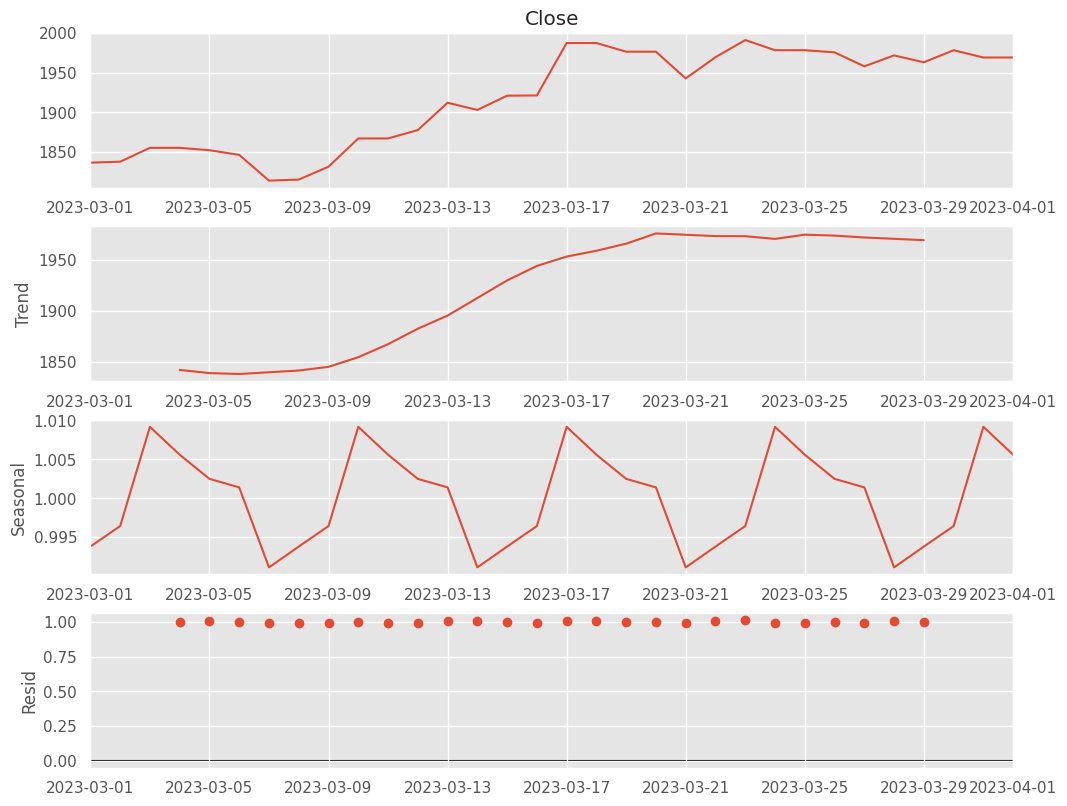

In [82]:
seasonal = seasonal_decompose(df["2023-03-01":"2023-04-01"],model='multiplicative')
fig = plt.figure()
fig = seasonal.plot()
fig.set_size_inches(10, 8)
# fig.savefig("seasonal_decompose.jpg")

In [83]:
# چون در نمودار بالا بخش سیسونال پنج بار تکرار داشتیم
# عدد پنج را در قسمت زیر در قرار دادم

model = sm.tsa.arima.ARIMA(train,order=(1, 1, 0),seasonal_order=(1, 1, 0, 5))
results = model.fit()
pred = results.predict(start=test.index.min(),end=test.index.max(),dynamic=False)



print("MSE : %.3f" %mean_squared_error(test, pred))
print("r2_score : %.3f" %r2_score(test,pred))
results.summary()

MSE : 398.158
r2_score : -0.116


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                           Close   No. Observations:                  700
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 5)   Log Likelihood               -2957.168
Date:                         Mon, 17 Jul 2023   AIC                           5920.336
Time:                                 07:31:45   BIC                           5933.963
Sample:                             07-04-2021   HQIC                          5925.606
                                  - 06-03-2023                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0245      0.036     -0.673      0.501      -0.096       0.047
ar.S.L5       -0.4533      0.028    -16.220      0.000      -0.508      -0.399
sigma2       293.7165     12.027     24.421      0.000     270.143     317.290
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                66.98
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

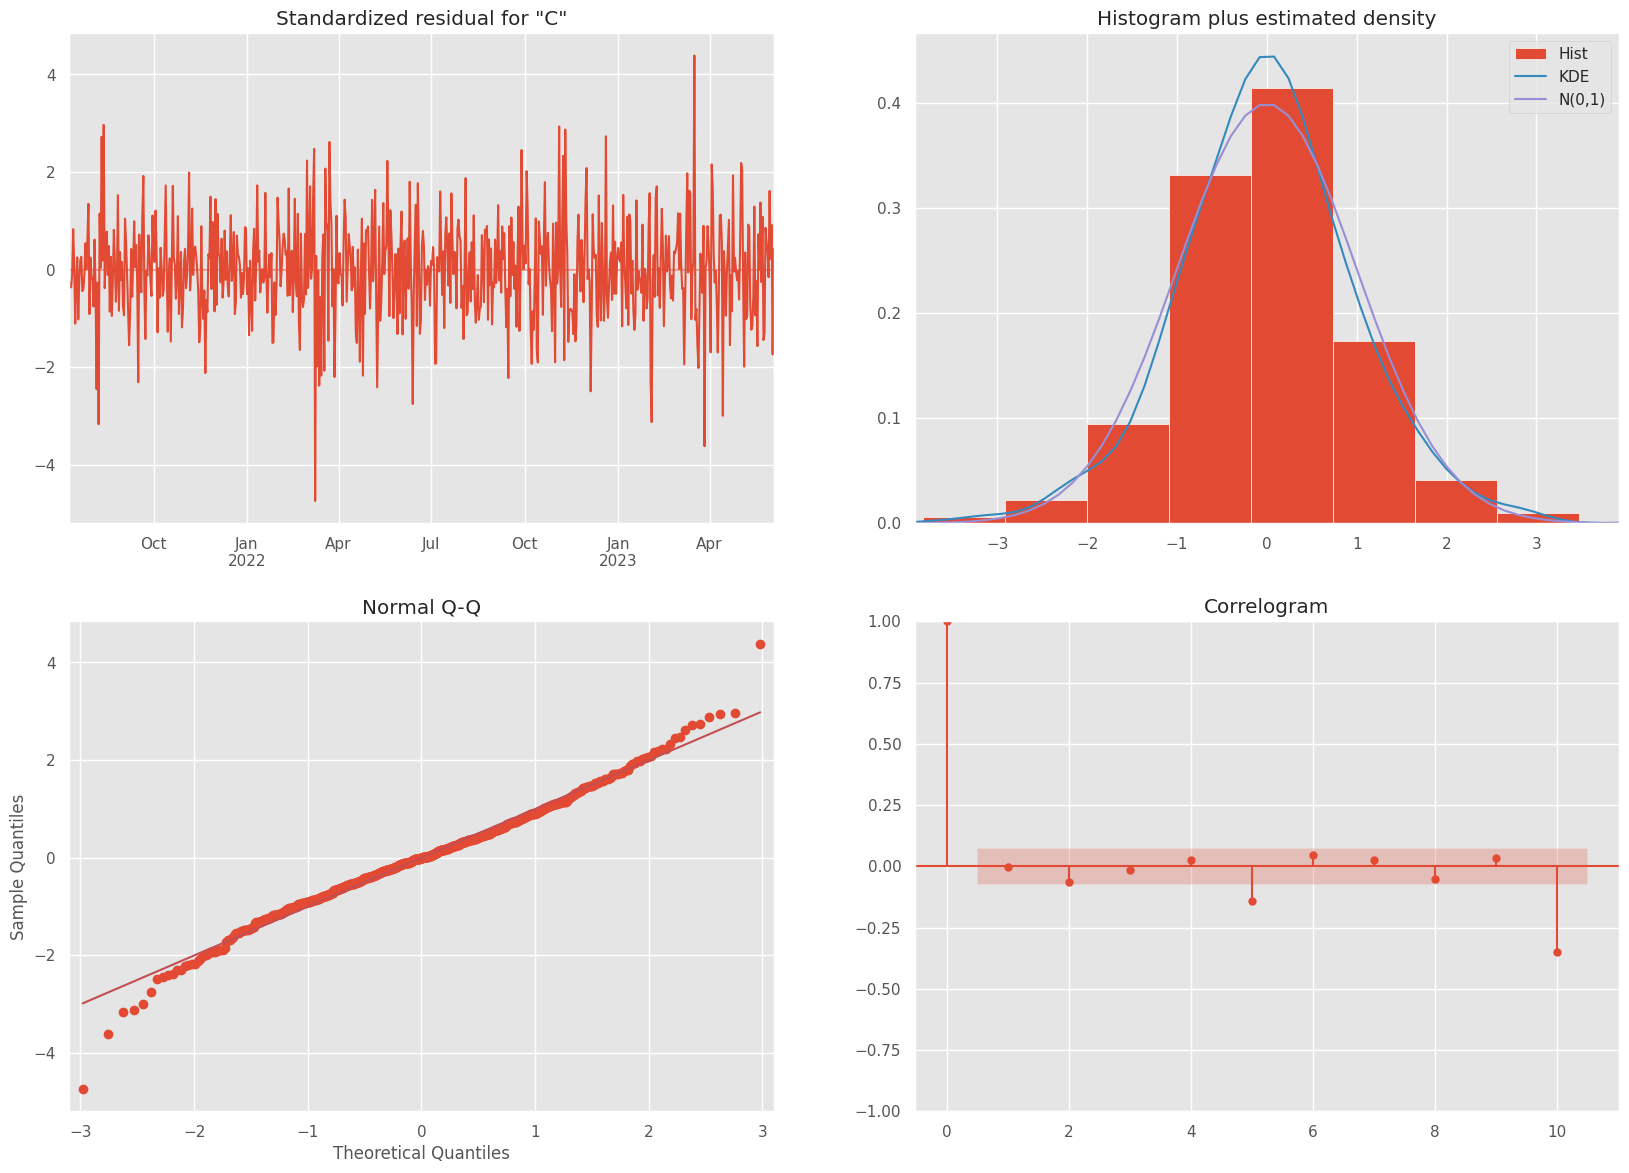

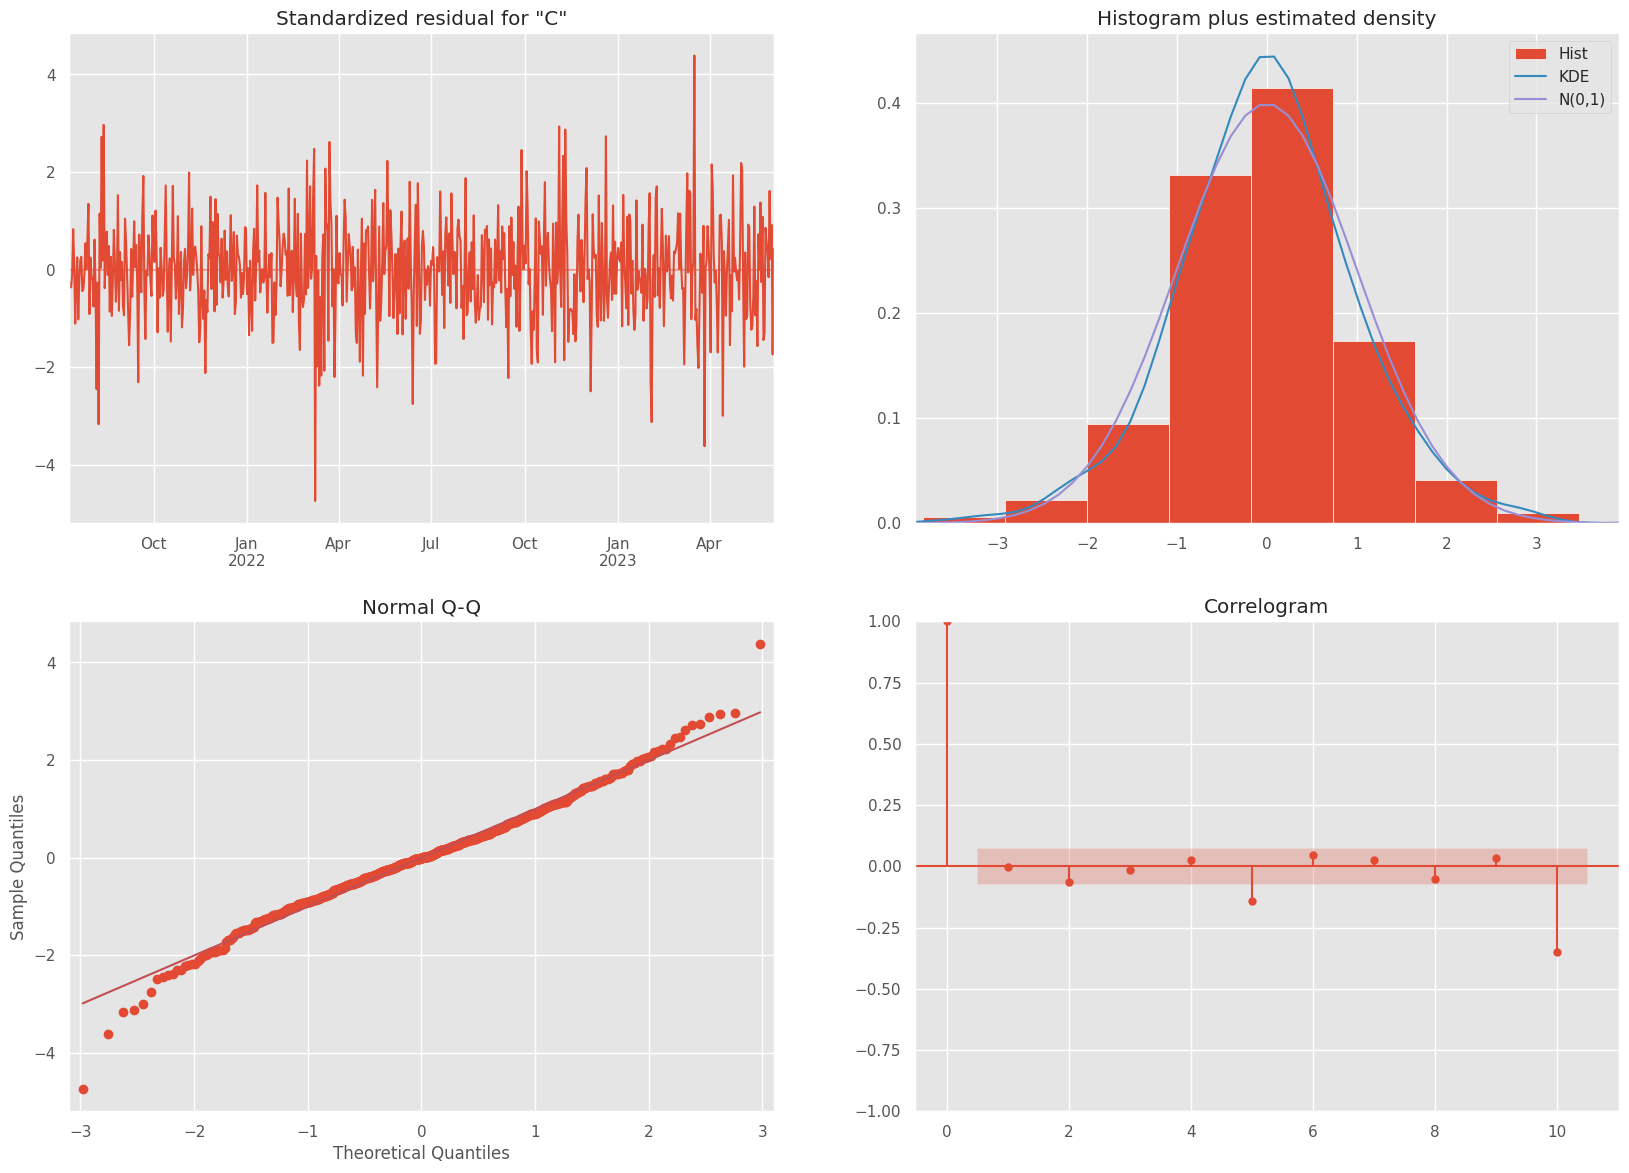

In [84]:
results.plot_diagnostics(figsize=(20,14))
# plt.savefig("plot_diagnostics.jpg")

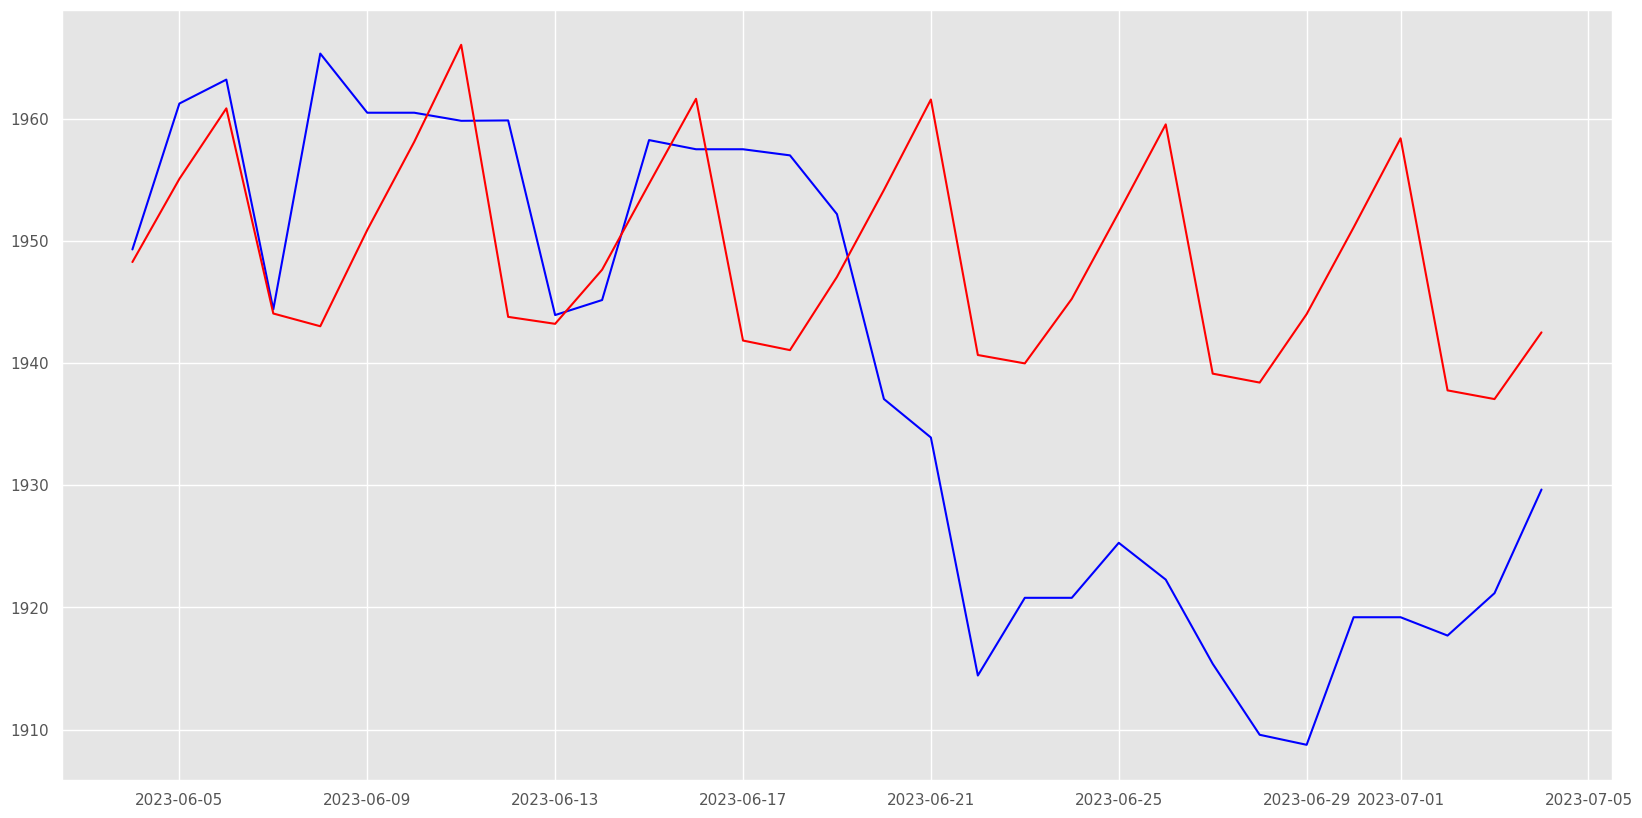

In [85]:
plt.plot(test,color = "blue")
plt.plot(pred,color="red")
plt.show()

In [86]:
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
# supress_warnings=True همه هشدار هارا خاموش میکند
# start_q , start_p , start_d   تست کردن پی کیو دی های مختلف که از
# error-action وقتی به ارور میخورد هشدار میدهد
#

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6028.087, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5859.702, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6029.646, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5777.772, Time=0.99 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=5747.456, Time=2.54 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=5710.137, Time=5.04 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=5693.911, Time=5.70 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=79.24 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=35.51 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=5692.464, Time=5.10 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=5708.956, Time=4.20 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=72.33 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=36.28 sec
 ARIMA(0,1,1)(5,1,0)[12]             : A

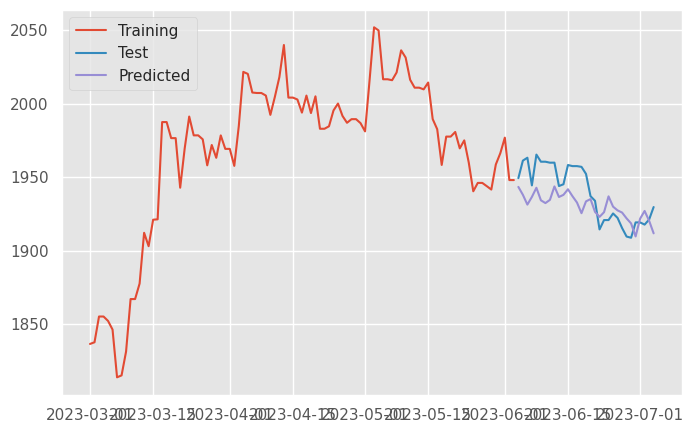

In [92]:
pred = pd.DataFrame(model.predict(n_periods = 31),index=test.index)
pred.columns = ['predicted_price']
pred


plt.figure(figsize=(8,5))
plt.plot(train["2023-03":],label="Training")
plt.plot(test,label="Test")
plt.plot(pred,label="Predicted")
plt.legend(loc = 'upper left')
# plt.savefig('Prection.jpg')
plt.show()


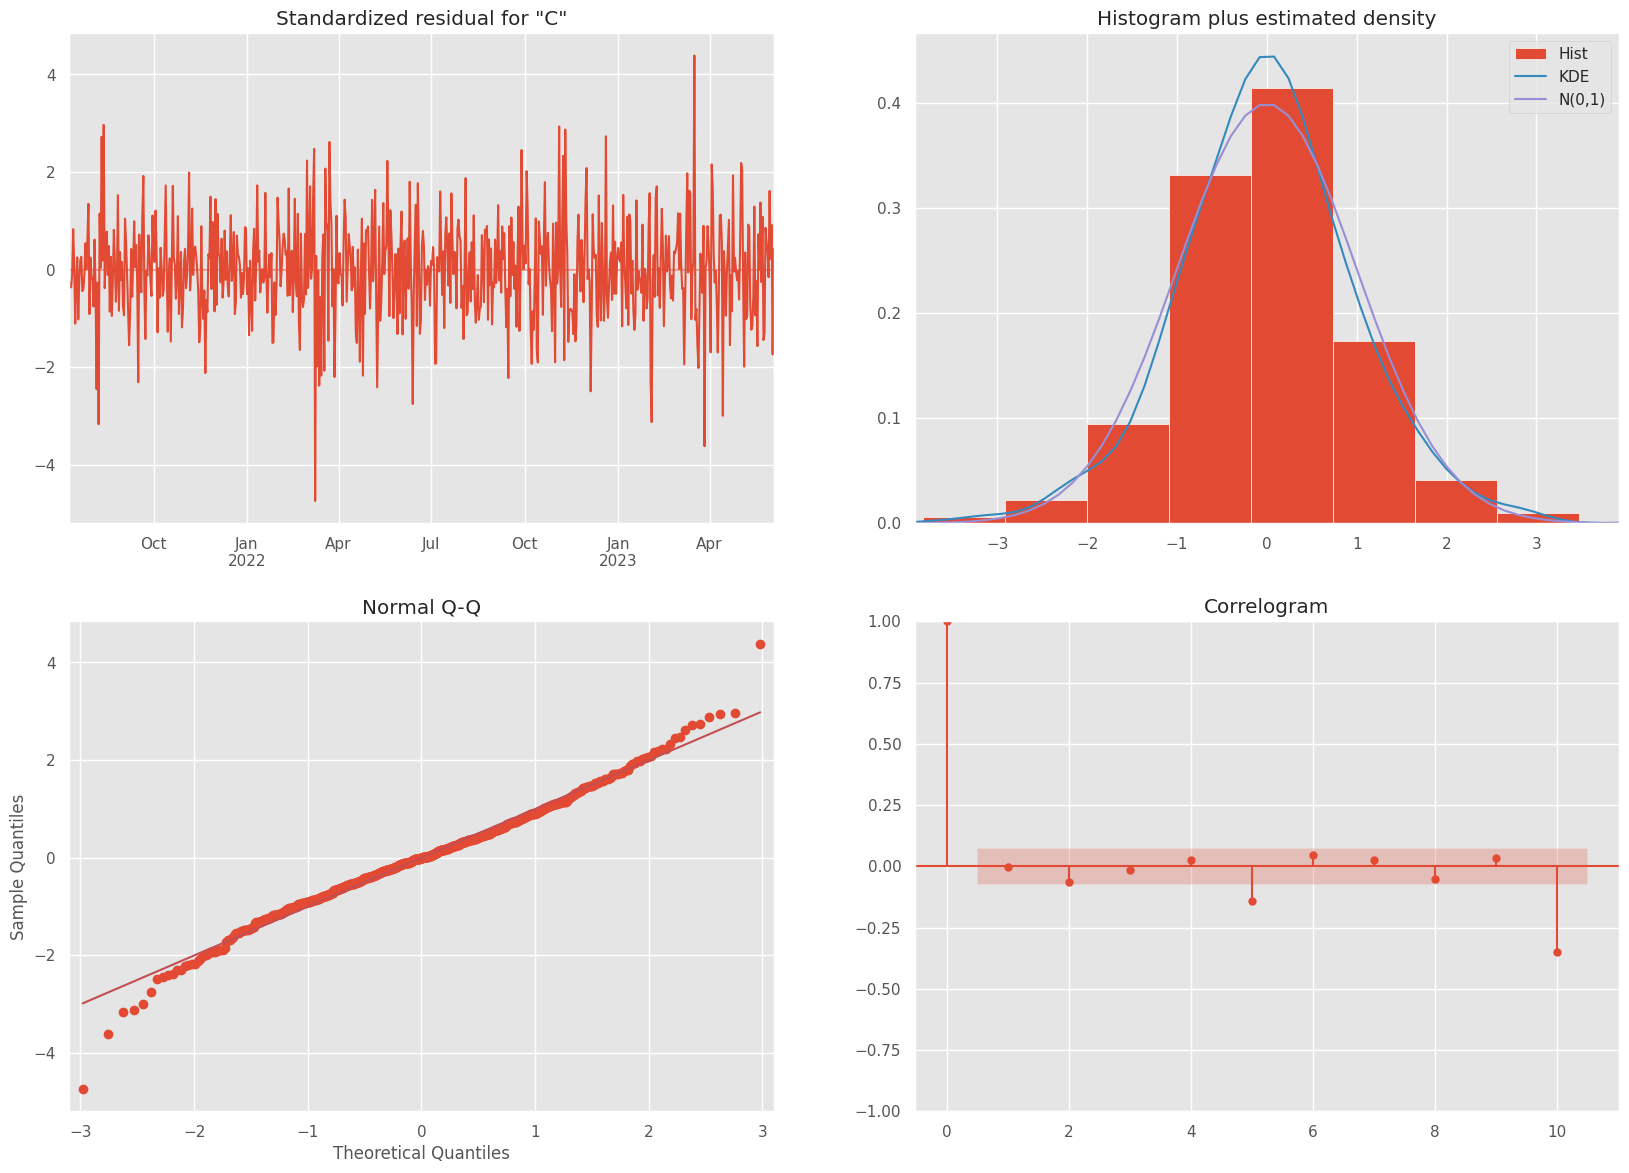

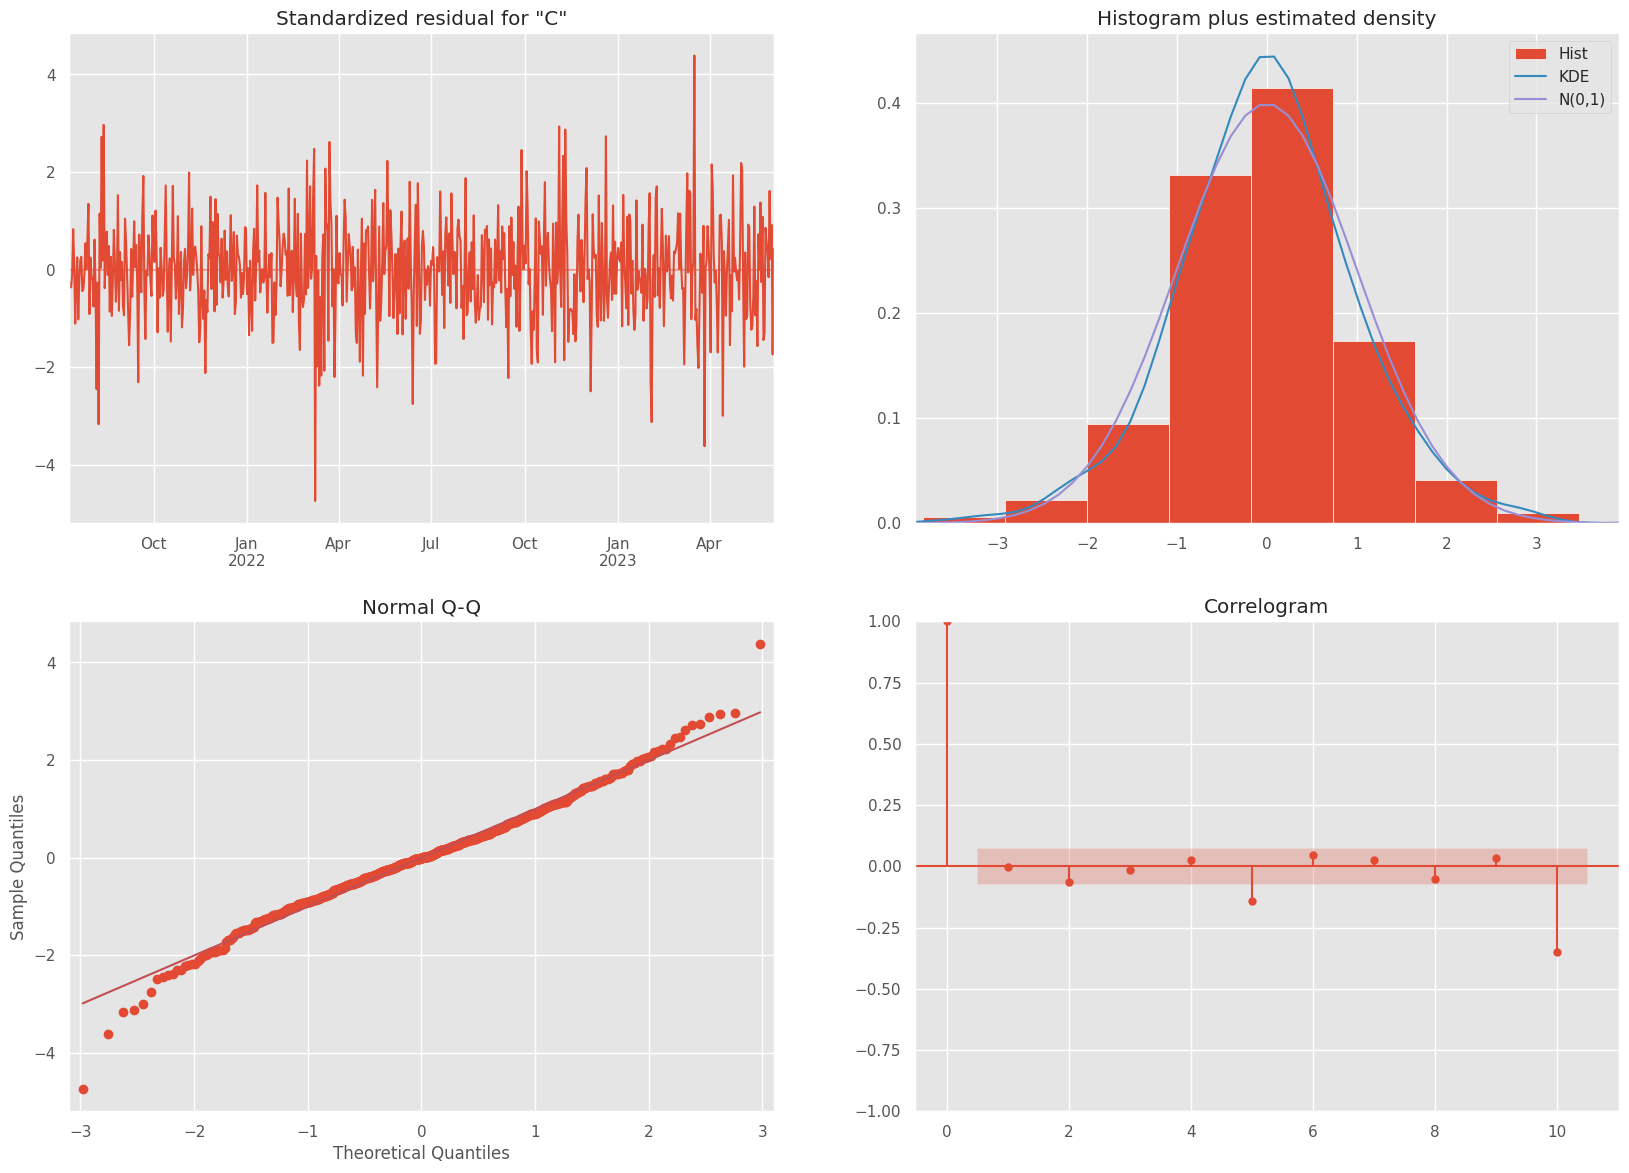

In [93]:
results.plot_diagnostics(figsize=(20,14))

In [94]:

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  700
Model:             SARIMAX(0, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -2840.232
Date:                            Mon, 17 Jul 2023   AIC                           5692.464
Time:                                    07:39:01   BIC                           5719.658
Sample:                                07-04-2021   HQIC                          5702.986
                                     - 06-03-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8057      0.040    -19.961      0.000      -0.885      -0.727
ar.S.L24      -0.6598      0.047    -14.113      0.000      -0.751      -0.568
ar.S.L36      -0.4886      0.048    -10.087      0.000      -0.584      -0.394
ar.S.L48      -0.3704      0.048     -7.648      0.000      -0.465      -0.275
ar.S.L60      -0.1694      0.041     -4.095      0.000      -0.250      -0.088
sigma2       224.2348      9.153     24.499      0.000     206.296     242.174
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                73.61
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
print("MSE : %.3f" %mean_squared_error(test, pred))
print("r2_score : %.3f" %r2_score(test,pred))

MSE : 278.519
r2_score : 0.219


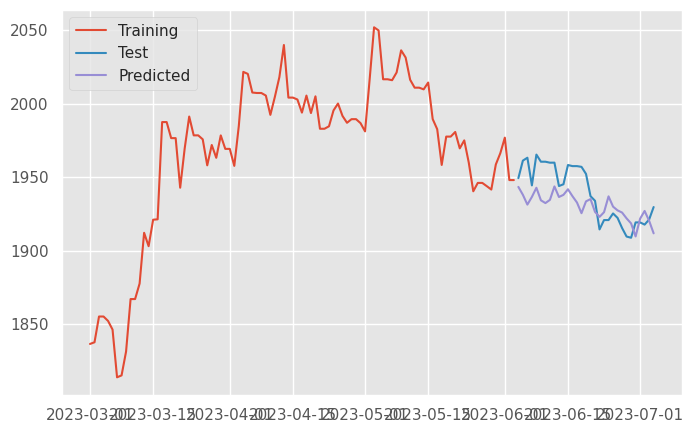

In [96]:
plt.figure(figsize=(8,5))
plt.plot(train["2023-03":],label="Training")
plt.plot(test,label="Test")
plt.plot(pred,label="Predicted")
plt.legend(loc = 'upper left')
# plt.savefig('Prection.jpg')
plt.show()